# Piecewise-stationary multi-armed bandit with hints

Observation are binary values (reward, no-reward) sampled from the binomial distributions with dynamic expected value $\vec{p}_{t,n}$, where $n$ denotes the chosen bandit. At each time step the reward expectations across bandits would either stay unchanged with $1-\rho$ or change to a new value (drawn from an uniform distribution over space of categorical distributions) with probability $\rho$. As a first step we will assume that bandits know the possible arm-reward mappings, but they do not know a priory which arm is associated with maximal reward probability. 

Here we will explore the variant in which an additional arm is introduced that provides unambiguous information about the best choice.

In [1]:
import numpyro as npyro
import numpyro.distributions as dist
import jax.numpy as np
from jax import random, lax, nn, ops

In [2]:
n = 10
rho = .01
B1 = (1 - rho) * np.eye(n) + rho * (np.ones((n, n)) - np.eye(n))/(n-1)
B1 = np.broadcast_to(B1, (1, n, n))

B2 = np.eye(n + 1)[:, None, :]
B2 = np.broadcast_to(B2, (n + 1, n + 2, n + 1))
B2 = np.concatenate([np.zeros((n + 1, n + 2, 1)), B2], -1)

B = [B1, B2]

eps = .4
base = .3
# n, 1 + n + 1 | 2
A1 = np.concatenate([np.stack([np.ones((n)), np.zeros((n))], -1)[:, None],
                     np.stack([1 - (np.eye(n) * eps + base * np.ones((n, n))), 
                               np.eye(n) * eps + base * np.ones((n, n))], -1),
                     np.stack([np.ones((n)), np.zeros((n))], -1)[:, None]], 
                    -2)

# n, 1 + n + 1 | 1 + n + 1
A2 = np.broadcast_to(np.eye(n + 2)[None], (n, n + 2, n + 2))

# n, 1 + n + 1 | n
A3 = np.concatenate([np.ones((n, n + 1, n))/n, np.eye(n)[:, None]], -2)

A = [A1, A2, A3]

# 4 | 2
A4 = np.array([[1 - base, base], [1 - base - eps, base + eps], [1., 0.], [1., 0.]])

# n, 4 | n
A5 = np.stack([
    np.ones((n, n))/n,
    np.ones((n, n))/n,
    np.ones((n, n))/n,
    np.eye(n)    
], -2)

# n, 1 + n + 1| 4
A6 = np.concatenate([np.array([0., 0., 1., 0.])[None, None].repeat(n, 0),
                     np.concatenate([np.stack([1 - np.eye(n), np.eye(n)], -1), np.zeros((n, n, 2))], -1),
                     np.array([0., 0., 0., 1.])[None, None].repeat(n, 0)], 
                    -2)

print(np.all(np.isclose(np.einsum('ijk,ko->ijo', A6, A4), A1)))
print(np.all(np.isclose(np.einsum('ijk,iko->ijo', A6, A5), A3)))
print(np.log(np.array([.01, .95, .02, .02])))
print(np.log(np.einsum('i,ij->j', np.array([.01, .95, .02, .02]), A4)))

True
True
[-4.6051702  -0.05129331 -3.912023   -3.912023  ]
[-1.1026202  -0.40346712]


In [ ]:
H_s = - np.sum(np.nan_to_num(np.log(A1)) * A1, -1) - np.sum(np.nan_to_num(np.log(A2)) * A2, -1)
H_s -= np.sum(np.nan_to_num(np.log(A3)) * A3, -1)
print(np.einsum('pl,cl->pc', B2[:, 0], H_s))

qo_c_p = np.einsum('pl,clo,clr,clq->pcorq', B2[:, 0], A1, A2, A3)

U = 2. * np.log(np.einsum('i,ij->j', np.array([.01, .98, .01]), A4))


G = np.sum( (np.nan_to_num(np.log(qo_c_p)) * qo_c_p).reshape(n+1, n, -1), -1)\
- np.sum(np.einsum('pcoqr->pco',qo_c_p) * U, -1) + np.einsum('pl,cl->pc', B2[:, 0], H_s)

print(nn.softmax(-G + G.sum(0)/(n + 1), 0)[:, 0])

qo_p = np.einsum('pl,c,clo,clr,clq->porq', B2[:, 0], np.ones(n)/n, A1, A2, A3)

G = np.sum( (np.nan_to_num(np.log(qo_p)) * qo_p).reshape(n+1, -1), -1)\
- np.sum(np.einsum('porq->po',qo_p) * U, -1) + np.einsum('pl,c,cl->p', B2[:, 0], np.ones(n)/n, H_s)


print(nn.softmax(-G + G.sum(0)/(n + 1), 0))

qc = np.zeros(n)
qc = ops.index_update(qc, ops.index[0], 1.)
qo_p = np.einsum('pl,c,clo->po', B2[:, 0], qc, A1)

G = np.sum( (np.nan_to_num(np.log(qo_p)) * qo_p).reshape(n+1, -1), -1)\
- np.sum(qo_p * U, -1) + np.einsum('pl,c,cl->p', B2[:, 0], qc, H_s)


print(nn.softmax(-G + G.sum(0)/(n + 1), 0))

In [ ]:
H_s = - np.sum(np.nan_to_num(np.log(A1)) * A1, -1)
H_s -= np.sum(np.nan_to_num(np.log(A3)) * A3, -1)

qc = np.zeros(n)
qc = np.ones(n)/n #ops.index_update(qc, ops.index[0], 1.)
qos_p = np.einsum('pl,c,clo,clq->pcloq', B2[:, 0], qc, A1, A3)
qo_p = np.einsum('pcloq->poq', qos_p)
qs_p = np.einsum('pcloq->pcl', qos_p)

U = np.log(np.einsum('i,ij->j', np.array([.01, .98, .01]), A4))
H = (H_s * qs_p).reshape(n+1, -1).sum(-1)

R = - np.sum(np.einsum('poq->po', qo_p) * U, -1) + (np.nan_to_num(np.log(qo_p)) * qo_p).reshape(n+1, -1).sum(-1)
print(nn.softmax(-H - R))

In [4]:
def log(x):
    return np.nan_to_num(np.log(x))

def logit(probs):
    lp = log(probs)
    return lp - np.nan_to_num(lp.sum(-1)[:, None])/probs.shape[-1]


def process(t, choices, states, rng_key):
    new_states = []
    axis = (0, 1)
    for i, b in enumerate(B):
        rng_key, _rng_key = random.split(rng_key)
        probs = lax.index_take(b, [choices[i], states[i]], axis)
        new_states.append(random.categorical(_rng_key, log(probs)))
        
       
    new_states = np.stack(new_states, 0)
    
    axis = tuple(range(states.shape[0]))
    outcomes = []
    for a in A:
        rng_key, _rng_key = random.split(rng_key)
        probs = lax.index_take(a, new_states, axis)
        outcomes.append(random.categorical(_rng_key, log(probs)))
    
    outcomes = np.stack(outcomes, 0)
    
    return outcomes, new_states

def model(t, agent, outcomes, choices, rng_key):
    logits = agent.update_beliefs(t, outcomes, choices)
    new_choices = []
    for logit in logits:
        rng_key, _rng_key = random.split(rng_key)
        new_choices.append(random.categorical(_rng_key, logit))
    
    return np.stack(new_choices, 0)

class Agent(object):
    def __init__(self, 
                 N,
                 nc,
                 na, 
                 gamma=1., 
                 P=np.array([.01, .95, .02, .02]), 
                 type='random', 
                 logging=False):
        
        self.N = N
        self.nc = nc
        self.na = na
        self.type = type
        self.U = np.log(np.einsum('i,ij->j', P, A4))
        self.C = np.log(P)
        self.gamma = gamma
        
        self.s1 = np.ones((N, nc))/nc
        self.s2 = np.zeros(N, dtype=np.int32)
        
        self.logging = logging
        if self.logging:
            self.prior = {"s1": [self.s1]}
            
        self.H_s = - np.sum(np.nan_to_num(np.log(A1)) * A1, -1) - np.sum(np.nan_to_num(np.log(A3)) * A3, -1)            
        self.H_s1_c = - np.sum(np.nan_to_num(np.log(A4)) * A4, -1) - np.sum(np.nan_to_num(np.log(A5)) * A5, -1)

        
    def posterior_probs(self, outcomes, choices):
        hint = outcomes[-1]
        location = outcomes[-2]
        reward = outcomes[-3]
        
        likelihood1 = lax.index_take(A1, [location, reward], (1, 2))
        likelihood2 = lax.index_take(A3, [location, hint], (1, 2))
        
        b = B1[choices[0]]
        prediction = np.einsum('nij,ni->nj', b, self.s1)
        assert prediction.shape == likelihood1.shape
        assert prediction.shape == likelihood2.shape
        
        posterior = likelihood1 * likelihood2 * prediction
        posterior /= posterior.sum(-1)[:, None]
        
        self.s1 = posterior
        self.s2 = location
        
        if self.logging:
            self.prior['s1'].append(posterior)
        
    def thompson_sampling(self):
        a = min(1., 2./(self.nc - 1))
        Pa = np.concatenate([np.eye(self.nc), a * np.ones((self.nc, 1))], -1)
        Pa /= Pa.sum(-1)[:, None]
        probs = np.einsum('ni,ij->nj', self.s1, Pa)
        return self.gamma * logit(probs)
    
    def expected_surprisal(self):
        qs1 = np.einsum('ni,ij->nj', self.s1, B1[0])
        qs2_pi = B2[:, self.s2].swapaxes(0, 1)
        
        H = np.einsum('ni,npj,ij->np', qs1, qs2_pi, self.H_s)
        
        qo_pi = np.einsum('ni,npj,ijo,ijq->npoq', qs1, qs2_pi, A1, A3)
        
        D = np.sum(((np.nan_to_num(np.log(qo_pi)) - self.U[:, None]) * qo_pi).reshape(self.N, self.na, -1), -1)
        
        return - self.gamma * (D + H)
    
    def expected_free_energy(self):
        
        qs1 = np.einsum('ni,ij->nj', self.s1, B1[0])
        qs2_pi = B2[:, self.s2].swapaxes(0, 1)
        
        qs1c_pi = np.einsum('ni,npj,ijc->npic', qs1, qs2_pi, A6)
        
        H = np.einsum('npic,ic->np', qs1c_pi, self.H_s1_c)
        
        qc_pi = qs1c_pi.sum(-2)
        D = np.sum((np.nan_to_num(np.log(qc_pi)) - self.C) * qc_pi, -1)
        
        return - self.gamma * (D + H)
        
    def update_beliefs(self, t, outcomes, choices):
        N = self.N
        if self.type == 'random':
            return [np.zeros((N, 1)), np.zeros((N, self.na))]
        else:
            self.posterior_probs(outcomes, choices)
            if self.type == 'thompson':
                logits = self.thompson_sampling()
            elif self.type == 'surprisal':
                logits = self.expected_surprisal()
            elif self.type == 'EFE':
                logits = self.expected_free_energy()
            else:
                logits = np.zeros((N, self.na))
            
            return [np.zeros((N, 1)), logits]            
            
    
def simulator(agent, process, model, N=100, trials=1000):
    
    rng_key = random.PRNGKey(4483342)
    
    states = np.zeros((2, N), dtype=np.int32)
    outcomes = np.zeros((2, N), dtype=np.int32)
    choices = np.zeros((2, N), dtype=np.int32)
    
    sequence={
        'outcomes': [],
        'choices': [],
        'states': []
    }
    carry = (outcomes, choices, states, rng_key)
    for t in np.arange(trials):
        outcomes, choices, states, rng_key = carry
        
        rng_key, _rng_key = random.split(rng_key)
        new_choices = model(t, agent, outcomes, choices, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        new_outcomes, new_states = process(t, new_choices, states, _rng_key)
        
        sequence['outcomes'].append(new_outcomes)
        sequence['choices'].append(new_choices)
        sequence['states'].append(new_states)
        carry = (new_outcomes, new_choices, new_states, rng_key)
    
    for key in sequence:
        sequence[key] = np.stack(sequence[key], 0)
    
    return sequence

In [5]:
N = 100
nc = n  # number of contexts
na = n + 1  # number of actions/options/arms
agent = Agent(N, nc, na, type='random')
sequence = simulator(agent, process, model, N=N)

correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
hints = (sequence['states'][:, 1] == na).astype(np.float32)
regret_random = eps * (1 - correct) + base * hints

In [16]:
agent = Agent(N, nc, na, type='thompson')
sequence = simulator(agent, process, model, N=N)
correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
hints = (sequence['states'][:, 1] == na).astype(np.float32)
regret_thompson = eps * (1 - correct) + base * hints

In [17]:
agent = Agent(N, nc, na, type='surprisal')
sequence = simulator(agent, process, model, N=N)
correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
hints = (sequence['states'][:, 1] == na).astype(np.float32)
regret_fe_bound = eps * (1 - correct) + base * hints

In [18]:
agent = Agent(N, nc, na, type='EFE')
sequence = simulator(agent, process, model, N=N)
correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
hints = (sequence['states'][:, 1] == na).astype(np.float32)
regret_fe_exact = eps * (1 - correct) + base * hints

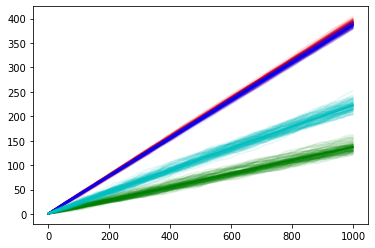

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(regret_random.cumsum(0), color='r', alpha=.1);
plt.plot(regret_random.cumsum(0).mean(-1), color='r', lw=2, label='random');

plt.plot(regret_thompson.cumsum(0), color='g', alpha=.1);
plt.plot(regret_thompson.cumsum(0).mean(-1), color='g', lw=2, label='thompson');

plt.plot(regret_fe_bound.cumsum(0), color='b', alpha=.05);
plt.plot(regret_fe_bound.cumsum(0).mean(-1), color='b', lw=2, label='surprisal');

plt.plot(regret_fe_exact.cumsum(0), color='c', alpha=.1);
plt.plot(regret_fe_exact.cumsum(0).mean(-1), color='c', lw=2, label='EFE');

In [6]:
from jax import vmap
N = 100
n = 10
trials = 600
fixed = regret_random.cumsum(0).mean(-1)[-1]/1000

def f(gamma, name):
    local_agent = Agent(N, nc, na, gamma=gamma, type=name)
    sequence = simulator(local_agent, process, model, N=N, trials=trials)
    hints = (sequence['states'][:, 1] == na).astype(np.float32)
    correct = (sequence['states'][:, 0] == sequence['states'][:, 1] - 1).astype(np.float32)
    regret = eps * (1 - correct) + base * hints
    
    vals = regret.sum(0)/trials
    perc = np.percentile(vals, [5, 50, 95], axis=-1)
    
    return perc[0], perc[1], perc[2]

vf = np.onp.vectorize(f)

gammas = np.array([0., .25, .5, .75, 1., 1.5, 2., 3., 5., 8., 12.])
regret_rate = {'random': [fixed] * len(gammas)}
for name in ['thompson', 'surprisal', 'EFE']:
    regret_rate[name] = vf(gammas, name)

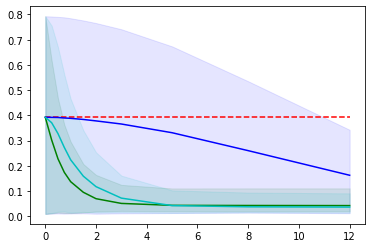

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(gammas, regret_rate['random'], 'r--')
for name, c in zip(['thompson', 'surprisal', 'EFE'], ['g', 'b', 'c']):
    m = regret_rate[name][1]
    lb = m - regret_rate[name][0]
    ub = m + regret_rate[name][-1]
    plt.plot(gammas, m, c)
    plt.fill_between(gammas, lb, y2=ub, color=c, alpha=.1)